<a href="https://colab.research.google.com/github/IsaacFigNewton/Taxonomic-Span-Categorization/blob/main/Agglomerative_ATC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import random
import spacy
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

import nltk
from nltk.corpus import gutenberg

nltk.download("gutenberg")

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [80]:
def dendrogram_to_graph(Z, embeddings, labels, max_depth=10):
    """
    Convert a dendrogram linkage matrix into a NetworkX graph.
    Each node stores its centroid as metadata.

    Args:
        Z: linkage matrix
        embeddings: original embeddings
        labels: labels for leaf nodes
        max_depth: (int or None) maximum depth of hierarchy to expand
                   depth=0 means only root, depth=1 adds its children, etc.
    """
    G = nx.DiGraph()
    n_samples = len(embeddings)

    # Add leaf nodes
    for i, (label, emb) in enumerate(zip(labels, embeddings)):
        G.add_node(i, label=label, centroid=emb.tolist())

    # Internal nodes
    for i, (c1, c2, dist, sample_count) in enumerate(Z):
        node_id = n_samples + i
        c1, c2 = int(c1), int(c2)

        members = [np.array(G.nodes[c]["centroid"]) for c in (c1, c2)]
        centroid = np.mean(members, axis=0)

        G.add_node(node_id, centroid=centroid.tolist(), size=sample_count)
        G.add_edge(node_id, c1, weight=dist)
        G.add_edge(node_id, c2, weight=dist)

    return G


def assign_nearest_words(G, df):
    word_embeddings = df.values
    words = df.index.tolist()

    for node, data in G.nodes(data=True):
        centroid = np.array(data["centroid"]).reshape(1, -1)
        sims = cosine_similarity(centroid, word_embeddings)[0]
        best_idx = np.argmax(sims)
        best_word = words[best_idx]
        G.nodes[node]["nearest_word"] = best_word
    return G

In [81]:
class TaxonomyPipeline:
    def __init__(self, model_name="all-MiniLM-L6-v2"):
        self.nlp = spacy.load("en_core_web_sm")
        self.embedder = SentenceTransformer(model_name)

    def process(self, text_or_texts):
        """
        Process a single string OR a list of plaintext corpora.
        Returns the graph after building taxonomy.
        """
        # Normalize input to list
        if isinstance(text_or_texts, str):
            corpora = [text_or_texts]
        elif isinstance(text_or_texts, list):
            corpora = text_or_texts
        else:
            raise TypeError("Input must be a string or list of strings.")

        # Step 1: Extract noun chunks from all corpora
        noun_chunks = []
        for text in corpora:
            doc = self.nlp(text)
            noun_chunks.extend([chunk.text.strip() for chunk in doc.noun_chunks])

        # Step 2: Get embeddings
        embeddings = self.embedder.encode(noun_chunks)

        # Step 3: Build dataframe (all noun chunks pooled)
        df = pd.DataFrame(embeddings, index=noun_chunks)

        # Step 4: Normalize
        pipeline = Pipeline([("scaler", StandardScaler())])
        normalized_embeddings = pipeline.fit_transform(embeddings)

        # Step 5: Clustering (linkage matrix)
        Z = linkage(normalized_embeddings, method="ward")

        # Step 6: Build graph
        G = dendrogram_to_graph(Z, embeddings, noun_chunks)

        # Step 7: Assign nearest words
        G = assign_nearest_words(G, df)

        return G

In [83]:
files = gutenberg.fileids()[:1]
corpora = [gutenberg.raw(fid)[:10000] for fid in files]

pipeline = TaxonomyPipeline()
G = pipeline.process(corpora)

/tmp/ipython-input-2487322677.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


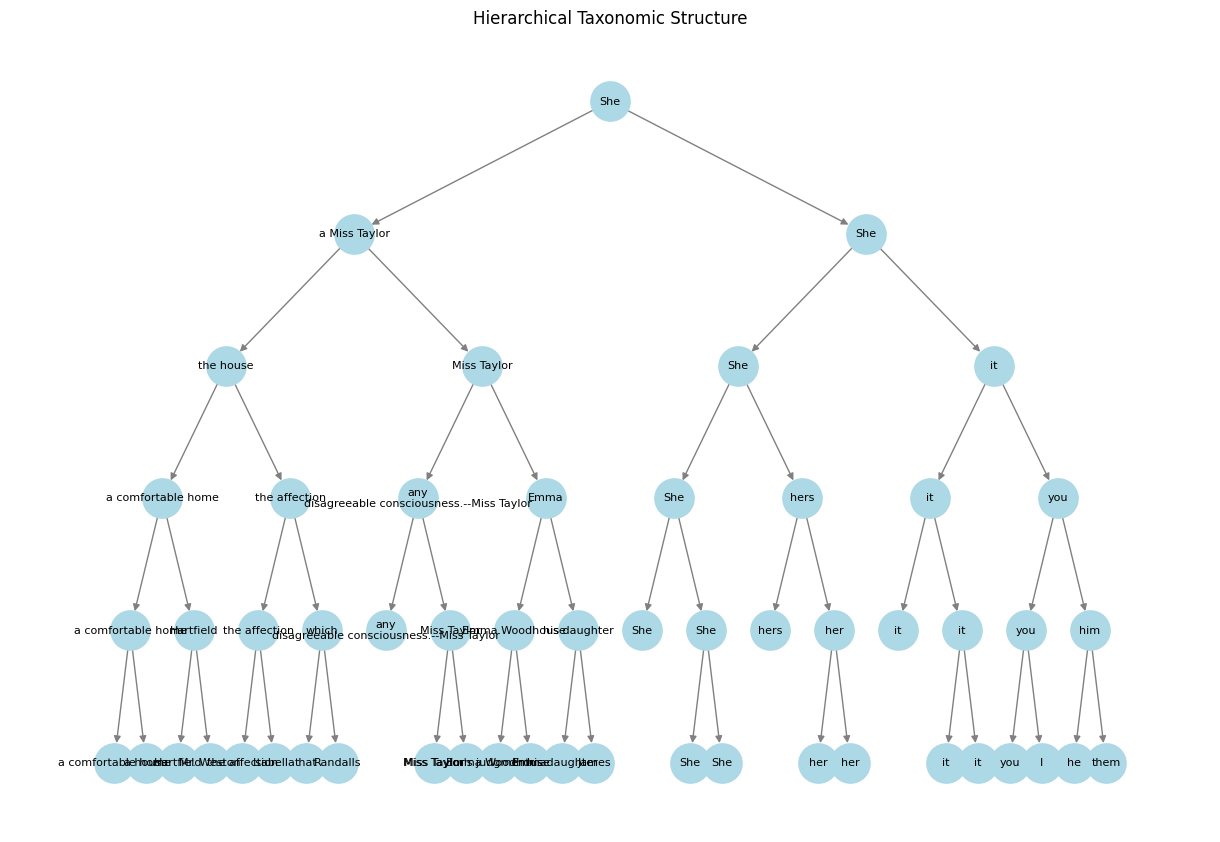

In [84]:
plot_hierarchical_graph(G, max_depth=5)